# VEHICLE DETECTION PROJECT

## Project Requirements

The Goal of this Project
In this project, your goal is to write a software pipeline to identify vehicles in a video from a front-facing camera on a car. The test images and project video are available in the project repository. There is an writeup template in the repostitory provided as a starting point for your writeup of the project.

The rubrik requirements of this project are the following:

* Histogram of Oriented Gradients (HOG)
    * Explain how (and identify where in your code) you extracted HOG features from the training images. Explain how you settled on your final choice of HOG parameters.
    * Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).
    
* Sliding Window Search
    * Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?
    * Show some examples of test images to demonstrate how your pipeline is working. What did you do to try to minimize false positives and reliably detect cars?
    
* Video Implementation
    * Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)
    * Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

* Discussion
    * Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

The steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Writeup / README

### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one. You can submit your writeup as markdown or pdf. 

You can find my read me content embedded in this Jupyter Notebook. It is easier to read about my choices and solutions and find the code and results in the very same place :-)

## Importing packages

In [1]:
import numpy as np
import pandas as pd
import os, re
import cv2
import time
from scipy import ndimage, misc
from skimage.feature import hog

In [2]:
from sklearn.externals import joblib
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
% matplotlib inline

## Useful functions

In [4]:
def convert_to_grayscale(image):
    """
    Grayscale conversion of an image
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def convert_to_L(image):
    """
    HLS conversion of an image
    L channel is returned
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    return L

def convert_to_S(image):
    """
    HLS conversion of an image
    S channel is returned
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    return S
        
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """
    transforms an image into hog features by providing
    pixels per cell and cell per block inputs
    """
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
def bin_spatial(img, size=(32, 32)):
    """
    Given an image returns binned color features
    """
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Given an image returns histogram features
    """
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(image, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    """
    Applying color conversion to the image and extracting both
    binned color features, as well as histograms of color
    """
    # apply color conversion if other than 'RGB'
    
    feature_image = np.copy(image)
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
    # Return list of feature vectors
    return np.concatenate((spatial_features, hist_features))

    
def feature_creation_pipeline(image, image_transformer, orient, pix_per_cell, cell_per_block, spatial_size, cspace='RGB'):
    """
    Concatenates all the feature creation steps, hog transformation and binned color features, as well as histogram of color
    """
    features = np.concatenate((get_hog_features(image_transformer(image), orient, pix_per_cell, cell_per_block),
                               extract_features(image, cspace, spatial_size)
                             ))
    return features

In [5]:
# Functions taken from http://www.pyimagesearch.com/ and https://github.com/jrosebr1/imutils/tree/master/imutils

def img_resize(image, width=None, height=None, inter=cv2.INTER_AREA):
    """
    A resize function
    """
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image
        # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation=inter)

    # return the resized image
    return resized

def pyramid(image, scale=1.5, minSize=(30, 30)):
    """
    The function creates a pyramid of reduced images
    using the scale function
    """
    # yield the original image
    yield image
 
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        image = img_resize(image, width=w)
 
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
 
        # yield the next image in the pyramid
        yield image

def sliding_window(image, stepSize, windowSize):
    """
    Function for creating a sliding window throught 
    an image. You can set the stepsize, too.
    """
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [6]:
def prepare_data(orient = 9, pix_per_cell = 8, cell_per_block = 2, 
                 color_filter=convert_to_grayscale, spatial_size=(32,32), cspace='RGB',
                 verbose=False):
    """
    Given the features' parameters (Hog transformation, histogram of colors and binned color features)
    the function extracts the feature vector directly from the image stored on disk
    """

    response = list()
    strata = list()
    data   = list()
    
    cars     = {'GTI_Far':dict(), 'GTI_Left':dict(), 'GTI_MiddleClose':dict(), 'GTI_Right':dict(), 'KITTI_extracted':dict(),}
    non_cars = {'Extras':dict(), 'GTI':dict()}
    images   = {'vehicles':cars, 'non-vehicles':non_cars}

    for k, directory in enumerate(images):
        for s, subdirectory in enumerate(images[directory]):
            for root, dirnames, filenames in os.walk(".\\"+directory+"\\"+subdirectory):
                if verbose:
                    print ("Found %i files in %s\\%s" % (len(filenames), directory, subdirectory))
                for filename in filenames:
                    if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
                        filepath = os.path.join(root, filename)
                        data.append(feature_creation_pipeline(ndimage.imread(filepath, mode="RGB"),
                                                              color_filter,
                                                              orient, pix_per_cell, cell_per_block, 
                                                              spatial_size, cspace)
                                    )
                        response.append(0 if "non-" in directory else 1)
                        strata.append(s+k*5)
                        
    return np.array(response), np.array(strata), np.array(data)

## Histogram of Oriented Gradients (HOG)

### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

I extracted HOG features by the function get_hog_features, which is the same as in the lessons. I first tested it with the lesson's parameters on both a vehicle and non-vehicle picture. As for as the parameters, I decided to test multiple settings by a randomized parameter search on the machine learning phase, testing combinations of:

color_filter   : [convert_to_grayscale, convert_to_S, convert_to_L]
orientation    : [6, 7, 8, 9, 10, 11, 12]
pix_per_cell   : [6, 8, 10, 12]
cell_per_block : [1, 2, 3]

As for as the color filter, I tried not only the grayscale but also the S and L channels of HLS filter.

### 2. Explain how you settled on your final choice of HOG parameters.

Basically, I let the randomized search define the best parameters for my Hog transformation.

Please note that you can know more about randomized search by reading this paper: Bergstra, J. and Bengio, Y., Random search for hyper-parameter optimization, The Journal of Machine Learning Research (2012)
                    

First I test with a vehicle image

In [7]:
img = ndimage.imread("vehicles\\KITTI_extracted\\17.png", mode="RGB")
print("Shape of images: %s" % str(img.shape))

Shape of images: (64, 64, 3)


In [8]:
pix_per_cell = 8
cell_per_block = 2
orient = 6
features, hog_image = get_hog_features(convert_to_grayscale(img), orient, pix_per_cell, cell_per_block, vis=True)

In [9]:
print("Shape of features: %s" % str(np.prod(features.shape)))

Shape of features: 1176


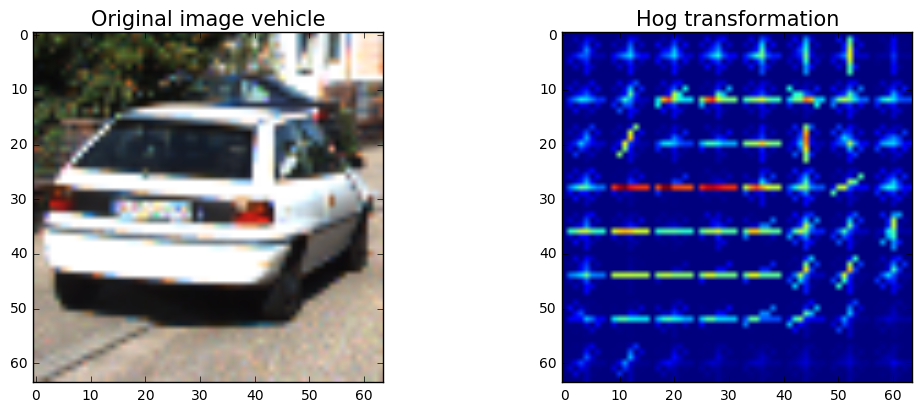

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original image vehicle', fontsize=15)
ax2.imshow(hog_image)
ax2.set_title('Hog transformation', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.7, bottom=0.)

Then I try the same with a non vehicle image, the shapes are different

In [11]:
img = ndimage.imread("non-vehicles\\GTI\\image58.png", mode="RGB")
print("Shape of images: %s" % str(img.shape))

Shape of images: (64, 64, 3)


In [12]:
pix_per_cell = 8
cell_per_block = 2
orient = 6
features, hog_image = get_hog_features(convert_to_grayscale(img), orient, pix_per_cell, cell_per_block, vis=True)

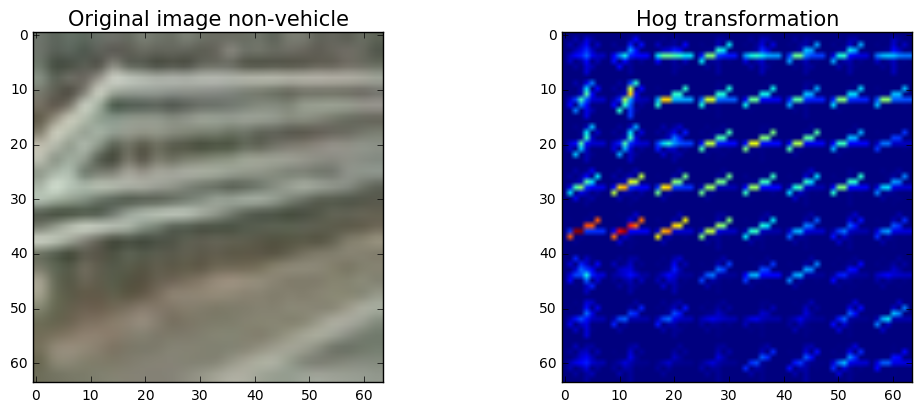

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original image non-vehicle', fontsize=15)
ax2.imshow(hog_image)
ax2.set_title('Hog transformation', fontsize=15)
plt.subplots_adjust(left=0., right=1, top=0.7, bottom=0.)

## Machine Learning Classifier

### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

As suggested by the lessons, I've tried adding binned color features, as well as histogram of color, put all these features together by the function prepare_data that can take many different parameters and extract the features directly from the stored images as prescribed by the parameters.

I also normalized the features with zero mean and unit variance (and recorded the way they have been normalized by the sklearn method StandardScaler).

After all that I applied the randomized search, looking for the best combinations and checking their performances both on the train set and on a 5 fold cross validation (the folds have been stratified by type of picture - vehicle or non-vehicle and the source such as GTI, Extras, KITTI). The learning algorithm has been liblinear, set in both regularization (l1 or l2), error measure (hinge or squared hinge), method of optimization (dueal or non dual).selection 

After various tries, the following parameters proved the most interesting (Accuracy of SVC : Train = 1.000 | Test = 0.989 (sd = 0.000)):

orient: 7, pix per cell: 8, cell per block: 3, filter: convert_to_L
penalty: l1, loss: squared_hinge, dual: False, C: 10.0
spatial size: (16, 16), cspace: HLS

Using these parameters the full model has been trained (using all the examples) and the model, the normalization function and feature creation functions have been stored to disk for later usage.

All the code relative to this part can be found in the Jupyter Notebook under the title "Machine Learning Classifier"

All the plan of elements of combinations is placed into the dictionary experiment_plan.
I set the resampling experiments to 60 (a number that in litterature is said to suffice for a complex search).
The procedure iterates throught all the experiments for 5 folds of cross-validation and records the results. When a combination is improving the previous results, it is printed on screen.

In [15]:
experiment_plan = {
                    'spatial_size': [32, 28, 24, 20, 16, 12, 8],
                    'color_filter': [convert_to_grayscale, convert_to_S, convert_to_L],
                    'orient' : [6, 7, 8, 9, 10, 11, 12],
                    'pix_per_cell' : [6, 8, 10, 12],
                    'cell_per_block' : [1, 2, 3],
                    'cspace' : ['RGB', 'LUV', 'HLS', 'YUV'],
                    'liblinear_settings' : [('l1','squared_hinge',False),('l2','hinge',True),
                                            ('l2','squared_hinge',True),('l2','squared_hinge',False)],
                    'C' : np.logspace(-3, 3, 7)
}

resampling = 10
results = {None:0.0}

for j in range(resampling):
    s = np.random.choice(experiment_plan['spatial_size'])
    spatial_size = (s, s)
    cspace = np.random.choice(experiment_plan['cspace'])
    color_filter = np.random.choice(experiment_plan['color_filter'])
    orient = np.random.choice(experiment_plan['orient'])
    pix_per_cell = np.random.choice(experiment_plan['pix_per_cell'])
    cell_per_block = np.random.choice(experiment_plan['cell_per_block'])
    penalty, loss, dual = experiment_plan['liblinear_settings'][np.random.randint(len(experiment_plan['liblinear_settings']))]
    C = np.random.choice(experiment_plan['C'])
    # color_filter, orient, pix_per_cell, cell_per_block, penalty, loss, dual, C
    response, strata, data = prepare_data(orient = orient, pix_per_cell = pix_per_cell, 
                                          cell_per_block = cell_per_block, color_filter=color_filter,
                                          spatial_size=spatial_size, cspace=cspace) 
    svc = LinearSVC(penalty=penalty, loss=loss, dual=dual, C=C, class_weight='balanced')
    # Stratification and shuffling
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    train_score = list()
    test_score = list()

    for train_index, test_index in skf.split(data, strata):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = response[train_index], response[test_index]

        scaler = StandardScaler().fit(X_train)
        scaled_X_train = (scaler.transform(X_train))
        scaled_X_test = (scaler.transform(X_test))

        svc.fit(scaled_X_train, y_train)
        train_score.append(svc.score(scaled_X_train, y_train))
        test_score.append(svc.score(scaled_X_test, y_test))
        prediction = svc.predict(scaled_X_test)

    train_score = np.mean(train_score)
    test_score = np.mean(test_score)
    test_var_score = np.std(test_score)
    best_score =  max(results.values())
    if test_score >= best_score:
        print ('orient: %i, pix per cell: %i, cell per block: %i, filter: %s, spatial size: %s, cspace: %s' % (orient, pix_per_cell, 
                                                                                                   cell_per_block, 
                                                                                                   str(color_filter).split()[1],
                                                                                                   spatial_size, cspace))
        print ('penalty: %s, loss: %s, dual: %s, C: %0.5f' % (penalty, loss, dual, C))
        print('Accuracy of SVC : Train = %0.3f | Test = %0.3f (sd = %0.3f)' % (train_score, test_score,
                                                                               test_var_score
                                                                              ))
    else:
        pass
            
    results[(color_filter, orient, pix_per_cell, cell_per_block, penalty, loss, dual, C, spatial_size, cspace)] = test_score

orient: 7, pix per cell: 10, cell per block: 2, filter: convert_to_grayscale, spatial size: (16, 16), cspace: LUV
penalty: l2, loss: hinge, dual: True, C: 0.01000
Accuracy of SVC : Train = 0.998 | Test = 0.986 (sd = 0.000)








orient: 7, pix per cell: 8, cell per block: 2, filter: convert_to_L, spatial size: (16, 16), cspace: YUV
penalty: l1, loss: squared_hinge, dual: False, C: 1.00000
Accuracy of SVC : Train = 1.000 | Test = 0.988 (sd = 0.000)


orient: 9, pix per cell: 8, cell per block: 3, filter: convert_to_L, spatial size: (20, 20), cspace: HLS
penalty: l2, loss: squared_hinge, dual: True, C: 0.00100
Accuracy of SVC : Train = 1.000 | Test = 0.989 (sd = 0.000)












Here is the best combination found:
    
* orient: 7, pix per cell: 8, cell per block: 3, filter: convert_to_L, spatial size: (16, 16), cspace: HLS
* penalty: l1, loss: squared_hinge, dual: False, C: 10.00000
* Accuracy of SVC : Train = 1.000 | Test = 0.989 (sd = 0.000)

In [16]:
color_filter, orient, pix_per_cell, cell_per_block = (convert_to_L, 7, 8, 3)
spatial_size, cspace = ((16,16), 'HLS')

Now we prepare the real model using these parameters

In [17]:
svc = LinearSVC(penalty='l1', loss='squared_hinge', dual=False, C=10.0, class_weight='balanced')

response, strata, data = prepare_data(orient, pix_per_cell, 
                                      cell_per_block, color_filter,
                                      spatial_size, cspace)

scaler = StandardScaler().fit(data)
scaled_train = (scaler.transform(data))

svc.fit(scaled_train, response)

LinearSVC(C=0.001, class_weight='balanced', dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

The parameters are incorporated into new functions and everything is saved to disk for future use

In [18]:
def hog_features(img, color_filter=color_filter, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block):
    return get_hog_features(color_filter(img), orient, pix_per_cell, cell_per_block)

def img_features(img, cspace=cspace, spatial_size=spatial_size):
    return extract_features(img, cspace, spatial_size)

In [19]:
joblib.dump(scaler, 'output_images//scaler.pkl')
joblib.dump(svc, 'output_images//svc.pkl')
joblib.dump(hog_features, 'output_images//hog_features.pkl')
joblib.dump(img_features, 'output_images//img_features.pkl')

['output_images//img_features.pkl']

## Sliding Window Search

### 1. Describe how (and identify where in your code) you implemented a sliding window search. How did you decide what scales to search and how much to overlap windows?

I used the pyramid function from OpenCV and a sliding window function found on Internet. I tried various scaling and by experimentation found the one that did not required many computations but was still quite efficient in detecting the veicles in the example pictures.

Noticing the frequency of false positive in unlikely places in the image, I applied some masking and cropping in order to limit the parts where I investigated the presence of cars. The functions region_of_interest, cut_half and cut_cover helped me.

I visualized how the pyramid function rescaled the filtered and cropped image and I projected the detected boxes on it. After having translated them into the original images I used them in order to create a heatmap and fitlered it by a threshold, as explained in the lessons.

In [20]:
scaler = joblib.load('output_images//scaler.pkl')
svc = joblib.load('output_images//svc.pkl')
hog_features = joblib.load('output_images//hog_features.pkl')
img_features = joblib.load('output_images//img_features.pkl')

In [21]:
img = ndimage.imread("test_images\\test5.jpg", mode="RGB")
print("Shape of images: %s" % str(img.shape))

Shape of images: (720, 1280, 3)


In [22]:
scaler = joblib.load('output_images//scaler.pkl')
svc = joblib.load('output_images//svc.pkl')

I revived the region_of_interest function from previous submissions

In [23]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def cut_half(img):
    return img[int(img.shape[0]*0.56):,:,:]

def cut_cover(img):
    return img[:img.shape[0]-50,:,:]

refitting_add = img.shape[0]-cut_half(img).shape[0]

In [24]:
img.shape

(720, 1280, 3)

Here you can see the region of interest applied to an image: it divides the image by the diagonal and it keeps only the right part

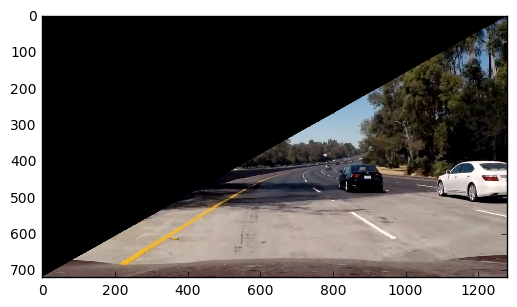

In [25]:
mask = np.array([[0,img.shape[0]],[img.shape[1],img.shape[0]],[img.shape[1],0]])
plt.imshow(region_of_interest(img,[mask]))
plt.show()

Applying also the cropping just limits the vision to the road, excluding the sky and the body of the car

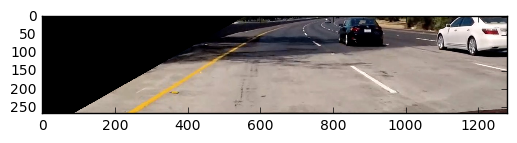

In [26]:
plt.imshow(cut_cover(cut_half(region_of_interest(img,[mask]))))
plt.show()

Here I apply the functions for heatmap that I learned from the lessons

In [27]:
def add_heat(heatmap, bbox_list):
    """
    Adds heat to an images, taken from the lessons
    """
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap, with intensity relative to the maximum detection
    return heatmap / max(np.max(heatmap),1)

def apply_threshold(heatmap, threshold):
    """
    Filters an heatmap by a threashold, taken from the lessons
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

from scipy.ndimage.measurements import label

def draw_labeled_bboxes(img, labels):
    """
    Given the labels from the scipy function,
    it draws the boxes around the detected objects
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Now it is time to try a cycle of pyramid creation and window sliding in order to detect cars in the image. All the single steps are detailed by an image showing the detected boxes in red. Finally the detected boxes are all projected into the original image.

(267, 1280, 3)


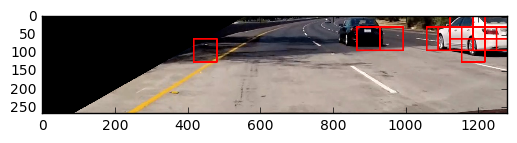

(177, 853, 3)


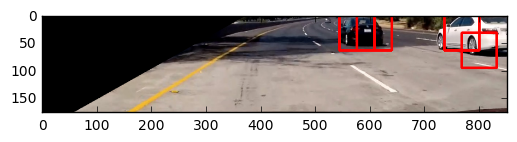

(117, 568, 3)


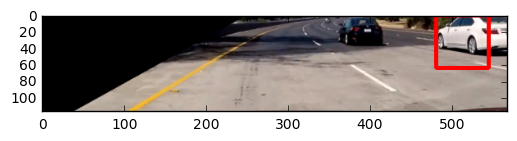

(77, 378, 3)


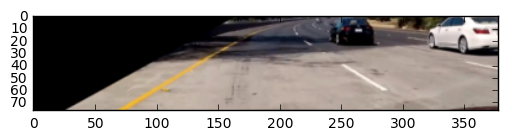

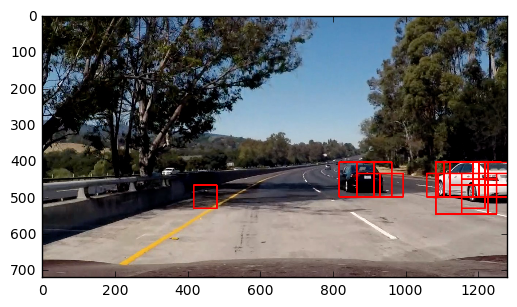

In [28]:
(winW, winH) = (64, 64)
# loop over the image pyramid
total_img = img.copy()
original_size = total_img.shape
heated = np.zeros(original_size)
detections = list()
processed_img = cut_cover(cut_half(region_of_interest(img,[mask])))
for l,resized in enumerate(pyramid(processed_img, scale=1.5)):
    if min(resized.shape[:2]) > min(winW, winH):
        print (resized.shape)
        B_rescale = original_size[1] / resized.shape[1]
        # loop over the sliding window for each layer of the pyramid
        clone = resized.copy()
        represent = True
        coordinates = list()
        cache = list()
        for (x, y, window) in sliding_window(resized, stepSize=int(winW*0.5), windowSize=(winW, winH)):
            # if the window does not meet our desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue
            cache.append(window)
            coordinates.append((x,y))
        hog_windows = [hog_features(w) for w in cache]
        img_windows = [img_features(w) for w in cache]
        features = np.concatenate((hog_windows, img_windows), axis=1)
        norm_features = scaler.transform(features)
        car_detect = svc.predict(norm_features)
        
        for n, v in enumerate(car_detect):
            if v==1:
                x, y = coordinates[n]
                # we plot a bounding box
                cv2.rectangle(clone, (x, y), (x + winW, y + winH), (255, 0, 0), 3)
                x_o, y_o = int(x*B_rescale), int(y*B_rescale)
                x_b, y_b = int(winW*B_rescale), int(winH*B_rescale)
                cv2.rectangle(total_img, (x_o, y_o+refitting_add), 
                              (x_o+x_b, y_o+y_b+refitting_add), (255, 0, 0), 3)
                detections.append([[x_o, (y_o+refitting_add)],[(x_o+x_b),(y_o+y_b+refitting_add)]])
                
        plt.imshow(clone)
        plt.show()
        
plt.imshow(total_img)
plt.show()

The boxes are then projected into a black image which is heated and filtered in order to show only the most likely positions of cars.

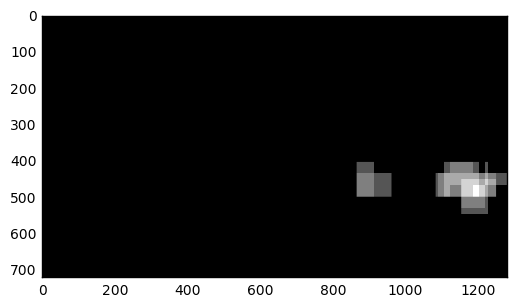

2 cars found


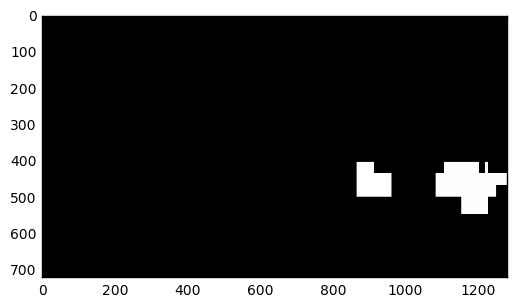

In [29]:
heatmap = apply_threshold(add_heat(heated, detections), 0.2)
plt.imshow(heatmap)
plt.show()
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

Finally the resulting box is applied to the original image (blue boxes)

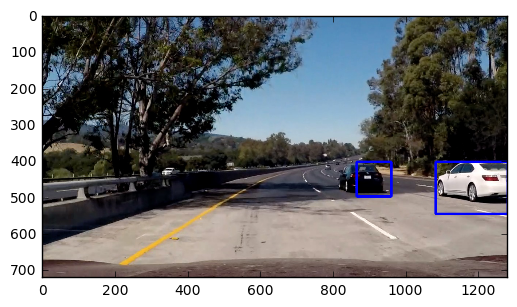

In [30]:
tracking_boxes = draw_labeled_bboxes(img, labels)
plt.imshow(tracking_boxes)
plt.show()

### 2. Show some examples of test images to demonstrate how your pipeline is working. What did you do to try to minimize false positives and reliably detect cars?

Having made the code work on a test image, I encapsualted it into a function and tested it against all the test images. I obtained very good results with no false positives. I re-used the function for the following video-processing.

In [31]:
img_processing = lambda img: cut_cover(cut_half(region_of_interest(img,[mask])))

def track_cars(img, processing, scaling= 1.5, threshold=0.20, precision=0.4, heated=np.zeros(img.shape)):
    (winW, winH) = (64, 64)
    # loop over the image pyramid 
    detections = list()
    processed_img = processing(img)
    for l,resized in enumerate(pyramid(processed_img, scale=1.4)):
        if min(resized.shape[:2]) > min(winW, winH):
            B_rescale = original_size[1] / resized.shape[1]
            # loop over the sliding window for each layer of the pyramid
            clone = resized.copy()
            represent = True
            coordinates = list()
            cache = list()
            for (x, y, window) in sliding_window(resized, stepSize=int(winW*precision), windowSize=(winW, winH)):
                # if the window does not meet our desired window size, ignore it
                if window.shape[0] != winH or window.shape[1] != winW:
                    continue
                cache.append(window)
                coordinates.append((x,y))
            
            hog_windows = [hog_features(w) for w in cache]
            img_windows = [img_features(w) for w in cache]
            features = np.concatenate((hog_windows, img_windows), axis=1)
            norm_features = scaler.transform(features)
            car_detect = svc.predict(norm_features)

            for n, v in enumerate(car_detect):
                if v==1:
                    x, y = coordinates[n]
                    # we plot a bounding box
                    x_o, y_o = int(x*B_rescale), int(y*B_rescale)
                    x_b, y_b = int(winW*B_rescale), int(winH*B_rescale)
                    detections.append([[x_o, (y_o+refitting_add)],[(x_o+x_b),(y_o+y_b+refitting_add)]])
                    
    heatmap = apply_threshold(add_heat(heated, detections), threshold)
    labels = label(heatmap)
    tracking_boxes = draw_labeled_bboxes(img.copy(), labels)
    return tracking_boxes, heatmap, labels    

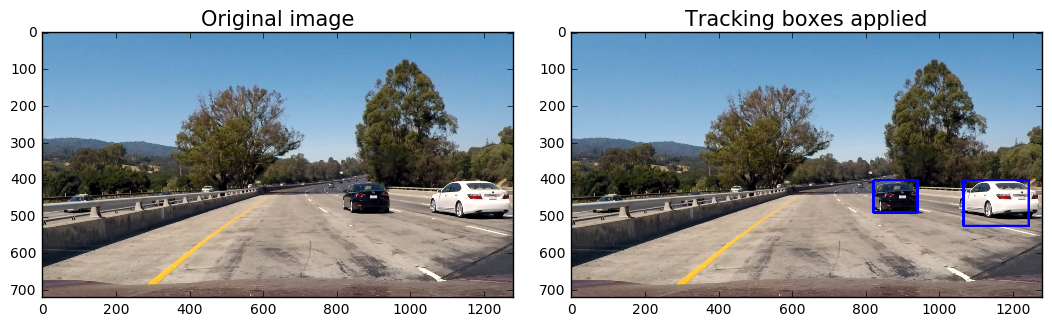

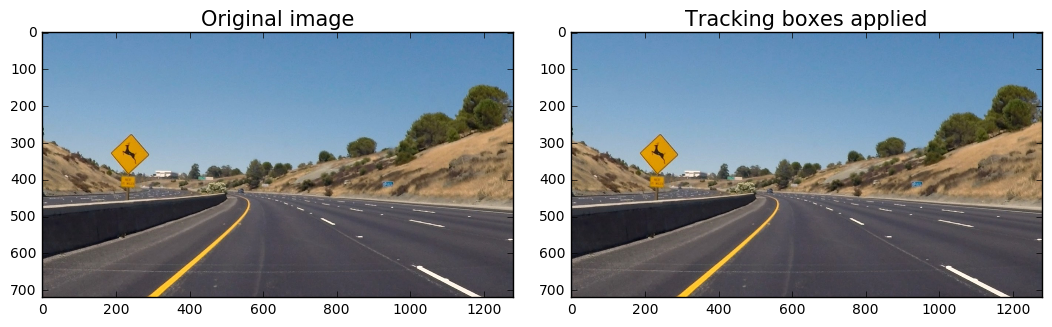

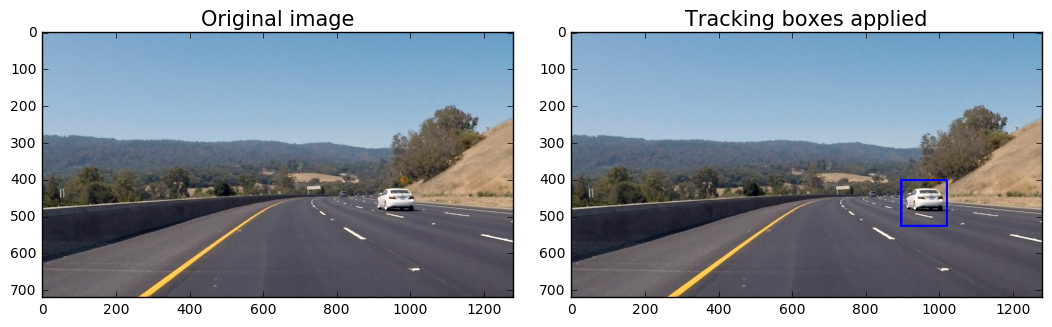

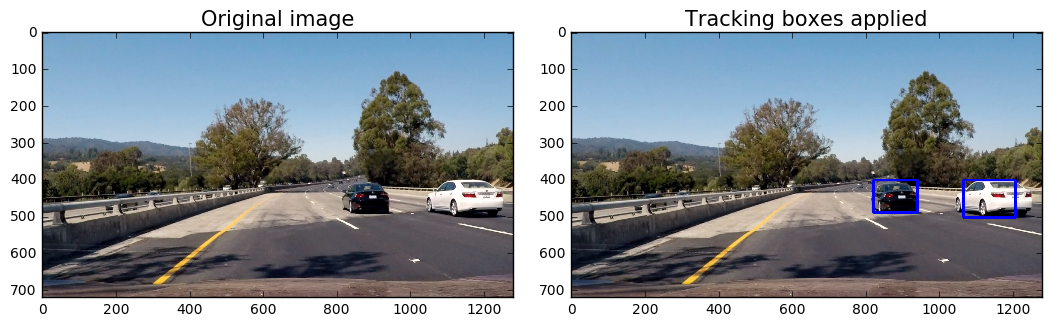

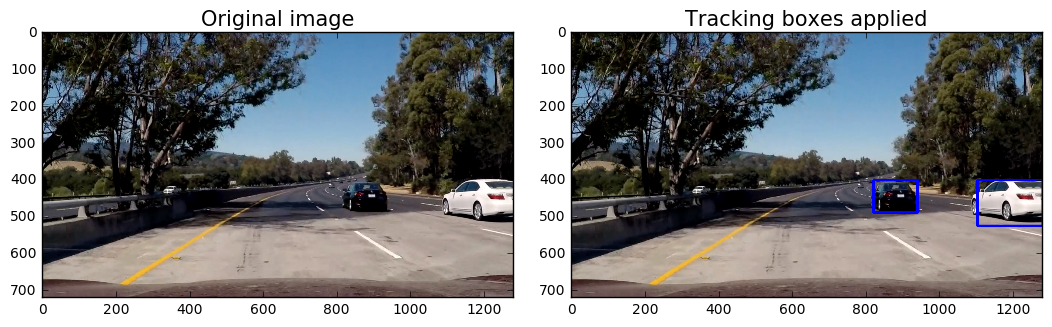

In [32]:
for f in range(1,6):
    img = ndimage.imread("test_images\\test"+str(f)+".jpg", mode="RGB")
    tracked, heatmap, labels = track_cars(img, img_processing, scaling= 1.5, threshold=0.20, 
                                          precision=0.6, heated=np.zeros(img.shape))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original image', fontsize=15)
    ax2.imshow(tracked)
    ax2.set_title('Tracking boxes applied', fontsize=15)
    plt.subplots_adjust(left=0., right=1, top=0.7, bottom=0.)

## Video Implementation

### 1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

The video is embedded in this Jupyter notepad and provided as a file in the submission. In any case, you can downaload it from: https://www.dropbox.com/s/fmzo8h05slgjqln/submission_project_video.mp4?dl=0


### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I simply took forward the idea of a heatmap making a persistent one. Simply stated, the previous heatmaps are used as the basis for creating a new one. Thus previous detections and actual detections fuse together and false positives loose strength in the representation because they tend to appear once and then never reappear again.

The class persistent_heatmap allows the record of the previous heatmap and provides the grounds for keeping on feeding the detection procedure, creating a stable result with new detections, even if they not perfect ones.

In [33]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [34]:
project_output = 'submission_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")

class persistent_heatmap():
    def __init__(self, scaling= 1.5, threshold=0.20, precision=0.6, persistance=40):
        self.heatmap = list()
        self.scaling = scaling
        self.threshold = threshold
        self.precision = precision
        self.persistance = persistance
    def processing_image(self, image):
        if len(self.heatmap)>0:
            tracked, heated, labels = track_cars(image, img_processing, self.scaling, 
                                                 self.threshold, self.precision, self.heatmap)
            self.heatmap = heated * (self.threshold*self.persistance)
        else:
            tracked, heated, labels = track_cars(image, img_processing, self.scaling, 
                                                 self.threshold, self.precision)
            self.heatmap = heated * (self.threshold* 120)
        return tracked            

tracking = persistent_heatmap(scaling= 1.5, threshold=0.20, precision=0.3, persistance=50)

white_clip = clip1.fl_image(tracking.processing_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video submission_project_video.mp4
[MoviePy] Writing video submission_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [35:58<00:01,  1.73s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: submission_project_video.mp4 

Wall time: 35min 59s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

As you can see there are only a few sporadic and short detections with shadows. The boxes are very small, maybe I could furthermore filter by box size.

## Discussion

### 1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

False positive are a real problem. Many objects can have the same colour or shape (gradient direction) as a car and the used features are many but not so detailed in recognizing a car as would be a deep learning model. I solved this weakness of the approach by masking (so only the road will be considered) and parameter fixing (minimizing the spotting of inexistent cars) but I fear that in different conditions more and more false positives can appear in the video processing and even stay there longer than they should thanks to the persistent heatmap that I devised. In particular, if there are shadows or markings on the road or the road is ruined in a way that could be misunderstood as a detection, there will be surely problems. Also stuff along the masking I made for the image can be falsely detected (traffic signs, houses, cars running on other side of the road).

I have some ideas in order to make the pipeline more robust:
* potentiate the machine learning procedure by bagging of different models (inserting tree models or just SVC variations)
* filter the detected boxes by size (area) discarding the small ones which may hint at something on the road. That may limit or make erratic also the car detection, though, which at the moment is quite stable. 
* create a real tracking system, not just a persistent heatmap. This real tracking system should label detected stuff by identifiers and project their trajectory in the next frames. That would help the correct rendering of the detected cars and should furthermore minimize the false positives.